In [217]:
'''
수정을 자주 할 것 같으니 최대한 잘게 쪼개서 적어보기
'''
import warnings
warnings.filterwarnings(action='ignore') # 경고 없애기

import pandas as pd
import numpy as np
import ast
import time
import json
import seaborn as sns
from PIL import Image

In [218]:
# 한글, -기호 깨짐 방지

import matplotlib.pyplot as plt

plt.rc("font", family="Malgun Gothic")
plt.rc("axes", unicode_minus=False)

In [219]:
# 그래프 선명하게 보여주기

%config InlineBackend.figure_format = 'retina'

In [220]:
# 데이터 불러오기

df1 = pd.read_csv("TFT_Challenger_MatchData.csv")
df2 = pd.read_csv("TFT_GrandMaster_MatchData.csv")
df3 = pd.read_csv("TFT_Master_MatchData.csv")
df4 = pd.read_csv("TFT_Diamond_MatchData.csv")
df5 = pd.read_csv("TFT_Platinum_MatchData.csv")
df_champ = pd.read_csv("TFT_Champion_CurrentVersion.csv")
df_item = pd.read_csv("TFT_Item_CurrentVersion.csv")

In [221]:
# 이후에 구분하기 위해 티어 컬럼 추가

df1['Tier'] = 'Challenger'
df2['Tier'] = 'GrandMaster'
df3['Tier'] = 'Master'
df4['Tier'] = 'Diamond'
df5['Tier'] = 'Platinum'

In [222]:
# 결측치 제거하기

df1 = df1.dropna()
df2 = df2.dropna()
df3 = df3.dropna()
df4 = df4.dropna()
df5 = df5.dropna()
df_champ = df_champ.dropna()
df_item = df_item.dropna()

In [223]:
total_df = pd.concat([df1, df2, df3, df4, df5], ignore_index=True)

In [224]:
# gameId별로 그룹을 묶었을 때 행의 개수가 8개인 게임만 남기기
total_df = total_df.groupby('gameId').filter(lambda x: len(x) == 8)

print(f"1단계) Id중복 제거 후 데이터 개수: {len(total_df)}개")

1단계) Id중복 제거 후 데이터 개수: 399680개


In [225]:
# 게임 시간이 600초(10분) 이상이고 3000초(50분) 미만인 데이터만 남기기
total_df = total_df[
    (total_df['gameDuration'] >= 600) & 
    (total_df['gameDuration'] < 3000)
]

print(f"2단계) 시간 이상치 제거 후 데이터 개수: {len(total_df)}개")

2단계) 시간 이상치 제거 후 데이터 개수: 399536개


In [226]:
# Round 수가 너무 적은 게임은 데이터 수집 목적에 맞지 않는 결과가 나온다고 생각
# lastRound가 20 이상인 데이터 남기기
total_df = total_df[total_df['lastRound'] >= 20]

print(f"3단계) 20라운드 이상 데이터 개수: {len(total_df)}개")

3단계) 20라운드 이상 데이터 개수: 396798개


In [227]:
# 게임을 플레이 해 본 경험을 바탕으로 champion 개수가 5개 이하면 정상적이지 않은 값이라는 것을 알고 있었으므로 이상치로 처리 
'''
ast.literal_eval 을 처음에 썼는데 코드 실행에 1분이 넘게 걸림.
첫 번째 해결 방안으로 json을 사용.
다른 방법이 없나 고민하다가 champion 이름별로 딕셔너리에 반드시 포함되는 key의 개수를 세면 되지 않을까?
생각한 방법으로 실행했더니 데이터 값도 일치했고 속도가 매우 빨랐다.
물론 모두 이런 방법을 사용할 수는 없기에 이후에는 json을 사용함.
'''
# 각 챔피언 정보 딕셔너리에 'star'라는 키 값을 counting!
# 'star' 개수가 5개보다 많은 행만 남기기

total_df = total_df[total_df['champion'].str.count("'star'") > 5]

print(f"4단계) champoin 6개 이상 데이터 개수: {len(total_df)}개")

4단계) champoin 6개 이상 데이터 개수: 394049개


In [228]:
# 시너지 이름을 '영어' -> '한글'로 매핑 준비

combination_map = {
    "Void": "공허", "MechPilot": "메카 파일럿", "Rebel": "반군", "Valkyrie": "발키리",
    "StarGuardian": "별 수호자", "Cybernetic": "사이버네틱", "Chrono": "시공간",
    "DarkStar": "암흑의 별", "SpacePirate": "우주 해적", "Celestial": "천상",
    "Blademaster": "검사", "ManaReaver": "마나 약탈자", "Sorcerer": "마법사",
    "Vanguard": "선봉대", "Protector": "수호자", "Mystic": "신비술사",
    "Brawler": "싸움꾼", "Mercenary": "용병", "Starship": "우주선",
    "Infiltrator": "잠입자", "Sniper": "저격수", "Blaster": "총잡이",
    "Demolitionist": "폭파광",
}

In [229]:
# 이전에 시즌2의 데이터가 들어와 있다는 사실을 알고 "매핑-> 다시 전처리" 과정을 거쳤었음. 이번에는 매핑까지 한번에
# 'TemplateTrait'와 같은 없애면 안되지만 매핑 불가능한 combination 숨김,
# 'set_'가 붙어 있는 combination 재가공,
#  한글에 할당되지 않는 combination 제거

def combination_mapping_json(comb_str):
    
    # 1. 오류 방지 코드
    if comb_str is None or pd.isna(comb_str):
        return comb_str
    
    # 이미 딕셔너리 객체라면 그대로 반환 (2차 실행 방지)
    if not isinstance(comb_str, str):
        return comb_str 

    # 2. JSON 파싱 단계
    try:
        # ast.literal_eval 대신 JSON 파싱 사용: 작은따옴표(')를 JSON 표준인 큰따옴표(")로 변환
        json_str = comb_str.replace("'", '"')
        comb_dict = json.loads(json_str)
            
    except json.JSONDecodeError:
        # JSON 파싱 실패 시, 문자열에 이상이 있으므로 None 반환 (이상치 검수/삭제)
        return None
    
    except Exception:
        # 그 외의 예외 처리
        return None
    
    # 3. 필터링 및 매핑
    new_dict = {}
    
    for key, value in comb_dict.items():
        
        # TemplateTrait 숨김 처리
        if key == "TemplateTrait":
            continue 
        
        clean_key = key
        
        # Set3_ 접두사 처리
        if key.startswith("Set3_"):
            clean_key = key.split("_")[1]
        
        # Set2_ 접두사 처리
        elif key.startswith("Set2_"):
            clean_key = key.split("_")[1]
        
        # 매핑 검증
        if clean_key not in combination_map:
            return None
        
        # 정상 데이터 -> 한글로 변환해서 저장
        k_kr = combination_map[clean_key]
        new_dict[k_kr] = value
        
    # 유효 시너지가 없으면 삭제
    if not new_dict:
        return None
            
    return new_dict


# 함수 적용 (이상치는 None으로 바뀜)
total_df['combination'] = total_df['combination'].apply(combination_mapping_json)

# 이상치(None) 행 제거
total_df = total_df.dropna(subset=['combination'])
final_count = len(total_df)

print(f"5단계) 시너지 매핑 완료 후 데이터 개수: {final_count}개")

5단계) 시너지 매핑 완료 후 데이터 개수: 390803개


In [230]:
# 챔피언 이름을 '영어' -> '한글'로 매핑 준비
champion_map = {
    "Graves": "그레이브즈", "Leona": "레오나", "Malphite": "말파이트", "Poppy": "뽀삐",
    "JarvanIV": "자르반 4세", "Xayah": "자야", "Zoe": "조이", "Ziggs": "직스",
    "KhaZix": "카직스", "Caitlyn": "케이틀린", "TwistedFate": "트위스티드 페이트",
    "Fiora": "피오라", "Darius": "다리우스", "Rakan": "라칸", "Lucian": "루시안",
    "Mordekaiser": "모데카이저", "Blitzcrank": "블리츠크랭크", "Sona": "소나",
    "Shen": "쉔", "XinZhao": "신 짜오", "Ahri": "아리", "Annie": "애니",
    "Yasuo": "야스오", "KaiSa": "카이사", "Neeko": "니코", "Lux": "럭스",
    "Rumble": "럼블", "MasterYi": "마스터 이", "Vi": "바이", "Shaco": "샤코",
    "Syndra": "신드라", "Ashe": "애쉬", "Ezreal": "이즈리얼", "Jayce": "제이스",
    "Karma": "카르마", "Kassadin": "카사딘", "VelKoz": "벨코즈", "Soraka": "소라카",
    "WuKong": "오공", "Irelia": "이렐리아", "Jhin": "진", "Jinx": "징크스",
    "ChoGath": "초가스", "Kayle": "케일", "Fizz": "피즈", "Gangplank": "갱플랭크",
    "Lulu": "룰루", "MissFortune": "미스 포츈", "Thresh": "쓰레쉬",
    "AurelionSol": "아우렐리온 솔", "Ekko": "에코", "Xerath": "제라스"
}

In [231]:
def champion_korean_json(champ_str):
    # 1. 오류 방지 코드
    if champ_str is None or pd.isna(champ_str):
        return champ_str
    
    # 이미 딕셔너리 객체라면 그대로 반환 (2차 실행 방지)
    if not isinstance(champ_str, str):
        return champ_str 

    # 2. JSON 파싱을 위한 문자열 전처리
    try:
        # 작은따옴표(')를 JSON 표준인 큰따옴표(")로 변환
        json_str = champ_str.replace("'", '"')
        
        # 3. JSON으로 파싱 
        champ_dict = json.loads(json_str)
            
    except json.JSONDecodeError:
        # JSON 파싱 실패 시, 문자열에 이상이 있다는 뜻이므로 None을 반환하여 해당 행 삭제
        return None
        
    except Exception:
        # 그 외의 예외 발생 시
        return None 
    
    # 4. 매핑
    new_dict = {
        champion_map.get(key, key): value 
        for key, value in champ_dict.items()
    }
    
    return new_dict

# total_df에 함수 적용
total_df['champion'] = total_df['champion'].apply(champion_korean_json)


In [232]:
total_df

,gameId,gameDuration,level,lastRound,Ranked,ingameDuration,combination,champion,Tier
0,KR_4247538593,2142.470703,8,35,1,2134.272217,"{'암흑의 별': 2, '수호자': 4, '반군': 1, '천상': 3, '신비술사...","{'자르반 4세': {'items': [27], 'star': 3}, '소나': {...",Challenger
1,KR_4247538593,2142.470703,9,35,2,2134.272217,"{'총잡이': 2, '용병': 1, '반군': 6, '검사': 3, '싸움꾼': 1...","{'말파이트': {'items': [7], 'star': 2}, '야스오': {'i...",Challenger
2,KR_4247538593,2142.470703,8,34,3,2073.459229,"{'사이버네틱': 1, '암흑의 별': 3, '폭파광': 1, '잠입자': 4, '...","{'카이사': {'items': [99, 2, 23], 'star': 2}, '애니...",Challenger
3,KR_4247538593,2142.470703,8,33,4,1998.146729,"{'총잡이': 1, '사이버네틱': 1, '암흑의 별': 1, '폭파광': 2, '...","{'카이사': {'items': [44, 37], 'star': 2}, '애니': ...",Challenger
4,KR_4247538593,2142.470703,9,33,5,1986.443237,"{'총잡이': 2, '폭파광': 2, '용병': 2, '반군': 6, '검사': 2...","{'직스': {'items': [], 'star': 1}, '야스오': {'item...",Challenger
...,...,...,...,...,...,...,...,...,...
399993,KR_4296831363,2049.954102,7,34,4,1862.439209,"{'시공간': 2, '사이버네틱': 1, '수호자': 2, '반군': 1, '검사'...","{'트위스티드 페이트': {'items': [58], 'star': 2}, '자야'...",Platinum
399994,KR_4296831363,2049.954102,8,33,5,1799.791870,"{'시공간': 2, '사이버네틱': 1, '잠입자': 1, '마나 약탈자': 1, ...","{'자야': {'items': [5], 'star': 2}, '야스오': {'ite...",Platinum
399995,KR_4296831363,2049.954102,8,38,2,2041.694946,"{'총잡이': 1, '암흑의 별': 1, '메카 파일럿': 1, '용병': 1, '...","{'뽀삐': {'items': [], 'star': 2}, '조이': {'items...",Platinum
399996,KR_4296831363,2049.954102,8,35,3,1911.133057,"{'총잡이': 2, '시공간': 1, '폭파광': 1, '용병': 1, '반군': ...","{'직스': {'items': [44, 48], 'star': 3}, '말파이트':...",Platinum


In [233]:
# Ranked 컬럼이 4 이하이면 True, 아니면 False

total_df['top4'] = total_df['Ranked'] <= 4

print(total_df[['Ranked', 'top4']].head())

   Ranked   top4
0       1   True
1       2   True
2       3   True
3       4   True
4       5  False


In [234]:
# 데이터 구조 변환 (Explode)
# 'champion' 컬럼의 딕셔너리를 분리하고 원본 인덱스를 포함하여 DataFrame 생성
df_champions = total_df.apply(lambda row: pd.Series(row['champion']), axis=1).stack().reset_index()

# 나중에 champion의 item 같은 세부 정보를 활용해 결과를 도출할 수도 있으니 만들어 놨음.
df_champions.columns = ['match_id', 'ChampionName', 'ChampionInfo'] 

# 필요한 매치 정보('Ranked', 'top4')를 인덱스로 매칭하여 다시 병합
# 'Ranked' 컬럼으로 최종 등수 반영
df_champions = df_champions.set_index('match_id').join(total_df[['Ranked', 'top4']])
df_champions = df_champions.reset_index(drop=True)

In [235]:
# 챔피언별 픽률, 평균 등수 계산

champion_picks = df_champions.groupby('ChampionName').agg(
    # 픽 횟수
    PickCount=('ChampionName', 'count'), 
    # 평균 등수 (Ranked 컬럼 사용)
    AvgPlacement=('Ranked', 'mean') 
)

# 픽률 계산
total_picks = champion_picks['PickCount'].sum()
champion_picks['PickRate'] = (champion_picks['PickCount'] / total_picks) * 100

# 픽 횟수를 기준으로 상위 10개 추출 (Top 10)
top_10_champs = champion_picks.sort_values(by='PickCount', ascending=False).head(10)

print("Top 10 챔피언 픽률 및 평균 등수")
print(top_10_champs[['PickRate', 'AvgPlacement']].round({'PickRate': 2, 'AvgPlacement': 2}))

Top 10 챔피언 픽률 및 평균 등수
              PickRate  AvgPlacement
ChampionName                        
바이                3.96          4.31
블리츠크랭크            3.84          4.40
카사딘               3.48          4.37
이즈리얼              3.39          4.37
미스 포츈             3.39          3.87
오공                3.27          4.40
말파이트              3.16          4.34
초가스               3.05          4.25
케일                2.93          4.27
쉔                 2.91          4.50


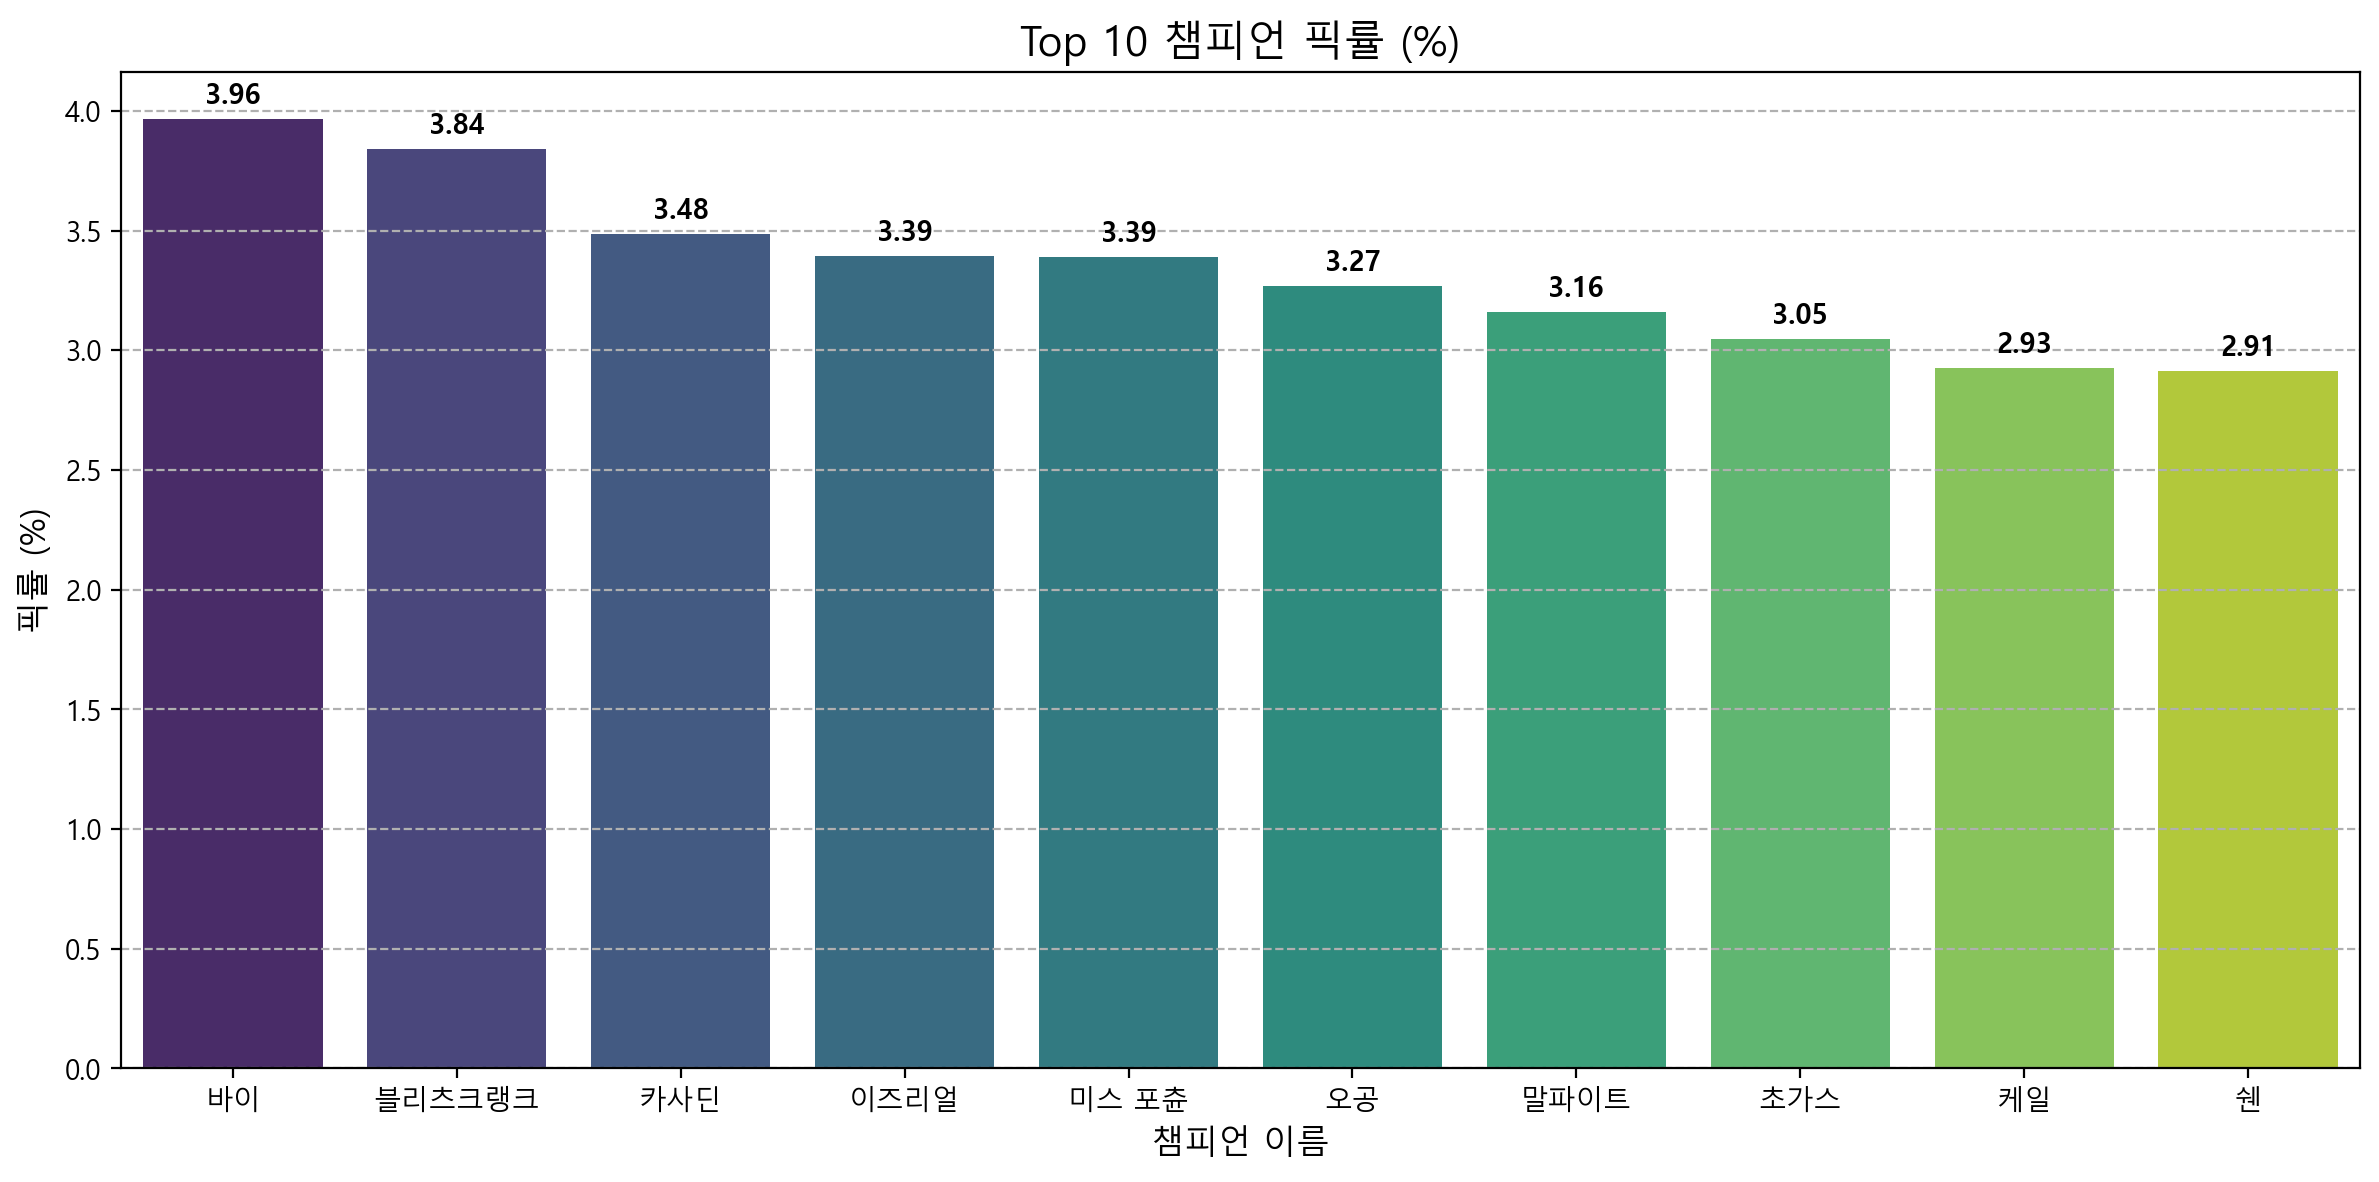

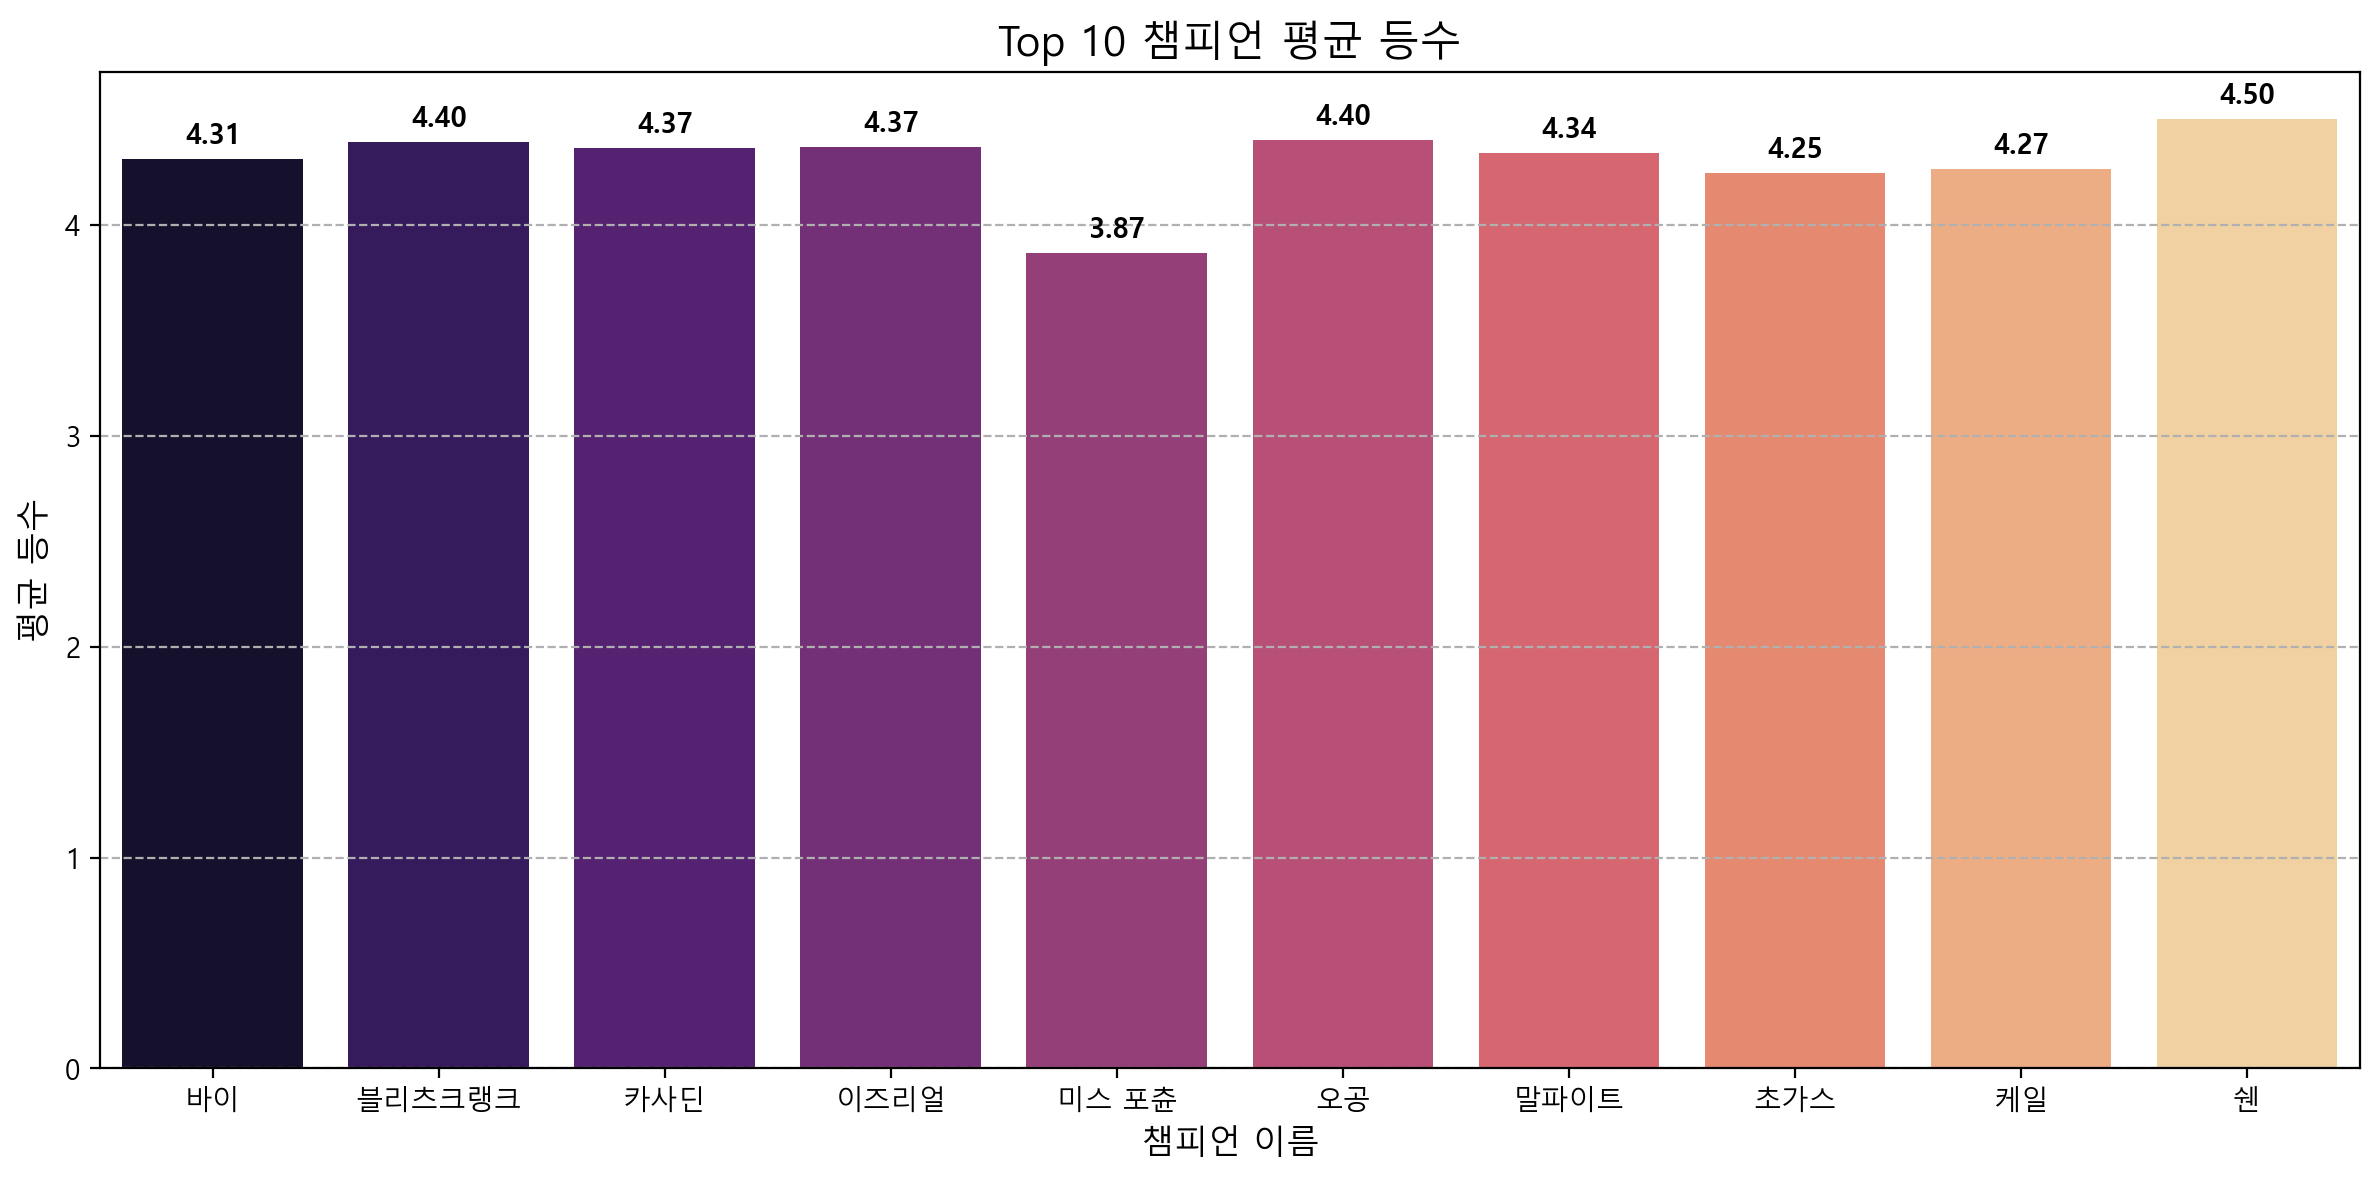

In [236]:
# 데이터 시각화!!!

# 픽률 시각화

plt.figure(figsize=(12, 6))
ax_pickrate = sns.barplot(
    x='ChampionName', 
    y='PickRate', 
    data=top_10_champs.reset_index(), 
    palette='viridis'
)
plt.title('Top 10 챔피언 픽률 (%)', fontsize=15)
plt.xlabel('챔피언 이름', fontsize=12)
plt.ylabel('픽률 (%)', fontsize=12)
plt.xticks(rotation=0, ha='center')
plt.grid(axis='y', linestyle='--')

# 픽률 값 표시 (소수점 둘째 자리까지)
for container in ax_pickrate.containers:
    ax_pickrate.bar_label(container, fmt='%.2f', padding=3, fontsize=10, color='black', fontweight='bold') 

plt.tight_layout()
plt.show()

# 평균 등수 시각화

plt.figure(figsize=(12, 6))
ax_placement = sns.barplot( # 변수 이름 변경
    x='ChampionName', 
    y='AvgPlacement', 
    data=top_10_champs.reset_index(), 
    palette='magma'
)
plt.title('Top 10 챔피언 평균 등수', fontsize=15)
plt.xlabel('챔피언 이름', fontsize=12)
plt.ylabel('평균 등수', fontsize=12)


plt.xticks(rotation=0, ha='center') 
plt.grid(axis='y', linestyle='--')

# 평균 등수 값 표시 (소수점 둘째 자리까지)
for container in ax_placement.containers:
    ax_placement.bar_label(container, fmt='%.2f', padding=3, fontsize=10, color='black', fontweight='bold') 

plt.tight_layout()
plt.show()